# Wind Speed Analysis for Wind Farm Potential in Ireland

The purpose of this project is to analyse historical wind data across Ireland to evaluate the suitability of locations for wind farms and to estimate their potential performance. 


This project focuses on:

1/ Getting historical wind speed data from meteorological stations

2/ Cleaning and normalising weather datasets

3/ Estimating wind power availability at different locations

4/ Wind turbines operation hours analysis

5/ Identifying trends in wind speeds over time

6/ Exploring additional weather variables relevant to wind energy

## 1/ Historical weather data

Raw data are sourced from Met Éireann - [The Irish Meteorological Service](https://www.met.ie/climate/available-data/historical-data):

Hourly Historical Weather data of 22 stations are downloaded as ZIP files, then unzipped and uploaded into the folder 'project/data' on Github as CSV files, each file corresponding to a location where the wind data is recorded. 

The variables are different from location to location, but all the CSVs contain these variables:

- date: Date and time 

- rain: Precipitation Amount (mm)

- temp: Air Temperature (C)	

- wdsp: Mean Wind Speed (knot)

- wddir: Predominant Wind Direction (degree)


## 2/ Data cleaning and normalisation with the function 'file_with_station'

The function file_with_station is used to clean, normalise, and prepare raw hourly weather data for wind energy analysis. The raw datasets contain metadata rows, missing values, and non-standard units, which must be processed before analysis.

Data cleaning steps performed by the function include:

- Identifying the row where the data begin by locating the header containing “date”.

- Removing all rows above the header to eliminate metadata and descriptive text.

- Retaining only relevant variables (date, wdsp, temp, rain) needed for wind analysis.

- Converting wind speed (wdsp) values to numeric format.

- Removing all rows before the first valid wdsp, non-zero wind speed measurement to ensure data reliability.


Data normalisation steps include:

- Converting the 'date' column into a standard datetime format.

- Filling missing wind speed values using linear interpolation over time.

- Converting wind speed from knots to metres per second (m/s).

- Creating new columns for different time formats (day, month, year, etc.) to help analyse wind patterns.

- Adding a station name so data from different locations can be compared.

- Energy-related steps:

    Calculating air density from temperature using the ideal gas law  ρ = p / (R · T)

    - R is the specific gas constant for dry air, value 287.05 J/(kg·K)

    - p = atmospheric pressure in Pascals (Pa = N/m²), value 101325 Pa, we assume a constant pressure

    - T = temperature in Kevin (K) --> Converts temperature from °C (most common in weather datasets) → Kelvin with df["temp"] + 273.15


    Estimating wind power from wind speed and air density: Power density = ½ × ρ × v³

    - ρ (df["rho"]) = air density (kg/m³)

    - v (df["wdsp_ms"]) = wind speed in meters per second

The function saves the cleaned and organised data as a new CSV file named after the station into the folder 'stationdata', ready for analysis and visualisation.

References: 

Wind power calculation

https://en.wikipedia.org/wiki/Wind_power

Density of air

https://en.wikipedia.org/wiki/Density_of_air

https://www.omnicalculator.com/physics/air-density



In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [2]:
def file_with_station(file,station):

    # -------- Delete uneccessary rows ------------------------------
    # Read file as text
    with open(file, "r", encoding="utf-8") as f:
        lines = f.readlines()

    # Find the row number where the data starts i.e. the row that contain 'date' in its first column
    header_row = None

    for i, line in enumerate(lines):
        # split on comma and strip spaces
        first_cell = line.split(",")[0].strip().lower()
        if first_cell == "date":
            header_row = i
            break

    # Read file as csv, delete uneccessary rows
    df = pd.read_csv(file, skiprows=header_row,low_memory=False)


    # --------- Keep only useful columns ----------------------------- 
    df = df[["date", "wdsp", "temp", "rain"]]

    # convert 'wdsp' to numeric
    df["wdsp"] = pd.to_numeric(df["wdsp"], errors="coerce")

    # find first row where wind speed is not NaN
    first_valid_value = df.loc[(df["wdsp"].notna()) & (df["wdsp"] != 0)].index.min()

    # drop rows before that
    df = df.loc[first_valid_value:].reset_index(drop=True)


    # --------- Fill up missing value ----------------------------------
    # modify the format of 'date'
    df['date'] = pd.to_datetime(df['date'], format='%d-%b-%Y %H:%M')

    # Set 'date' as index as interpolate based on actual time differences between index values
    df = df.set_index('date')

    # Interpolate missing windspeed (linear is best for meteorological data)
    # Only fill gaps up to 1 week (7 × 24 = 168 consecutive missing values)
    df['wdsp'] = df['wdsp'].interpolate(method='time', limit=168, limit_direction='both', limit_area='inside')

    
    # --------- Add new columns ---------------------------------------
    # Bring 'date' back as a column
    df = df.reset_index()

    # Add a column that contains only date details
    df['dateonly']= df['date'].dt.date

    # Add a column that contains only year
    df['year'] = pd.to_datetime(df['date']).dt.strftime('%Y')

    # Add a column that contains only month-year
    df['yearmonth'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m')

    # Add a column that contains only month
    df['month'] = pd.to_datetime(df['date']).dt.strftime('%m')

    # Add a column that contains only hour
    df['hour'] = pd.to_datetime(df['date']).dt.strftime('%H:%M')

    # convert the measurement of wdsp into m/s
    df["wdsp_ms"] = df["wdsp"] * 0.5144444444

    # Add a column which takes the station name as value
    df["station"]= station

    # convert 'temp' to numeric
    df["temp"] = pd.to_numeric(df["temp"], errors="coerce")
    R = 287.05       # J/(kg·K)
    p = 101325       # Pa (assumed constant)
    
    # Add column 'rho' - air density
    df["rho"] = p / (R * (df["temp"] + 273.15))

    # Add column 'power' - wind power density
    df['power'] = 0.5 * df["rho"] * df["wdsp_ms"]**3


    # --------- Save as a new file in folder stationdata ----------------
    df.to_csv(f"stationdata/{station}.csv", index=False)
    print(f"The file {station}.csv is now created.")

In [ ]:
file_with_station("data/hly275.csv","Mace Head")
file_with_station("data/hly375.csv","Oak Park")
file_with_station("data/hly518.csv","Shannon Airport")
file_with_station("data/hly532.csv","Dublin Airport")
file_with_station("data/hly575.csv","Moore Park")
file_with_station("data/hly675.csv","Ballyhaise")
file_with_station("data/hly775.csv","Sherkin Island")
file_with_station("data/hly875.csv","Mullingar")
file_with_station("data/hly1075.csv","Roches Point")
file_with_station("data/hly1175.csv","Newport")
file_with_station("data/hly1375.csv","Dunsany")
file_with_station("data/hly1475.csv","Gurteen")
file_with_station("data/hly1575.csv","Malin Head")
file_with_station("data/hly1775.csv","Johnstown Castle")
file_with_station("data/hly1875.csv","Athenry")
file_with_station("data/hly1975.csv","Mt Dillon")
file_with_station("data/hly2075.csv","Finner")
file_with_station("data/hly2175.csv","Claremorris")
file_with_station("data/hly2275.csv","Valentia Observatory")
file_with_station("data/hly2375.csv","Belmullet")
file_with_station("data/hly3904.csv","Cork Airport")
file_with_station("data/hly4935.csv","Knock Airport")

The file Mace Head.csv is now created.
The file Oak Park.csv is now created.
The file Shannon Airport.csv is now created.
The file Dublin Airport.csv is now created.
The file Moore Park.csv is now created.
The file Ballyhaise.csv is now created.
The file Sherkin Island.csv is now created.
The file Mullingar.csv is now created.
The file Roches Point.csv is now created.
The file Newport.csv is now created.
The file Dunsanny.csv is now created.
The file Gurteen.csv is now created.
The file Malin Head.csv is now created.
The file Johnstown Castle.csv is now created.
The file Athenry.csv is now created.
The file Mt Dillon.csv is now created.
The file Finner.csv is now created.
The file Claremorris.csv is now created.
The file Valentia Observatory.csv is now created.
The file Belmullet.csv is now created.
The file Cork Airport.csv is now created.
The file Knock Airport.csv is now created.


## 3/ Wind Power Potential Analysis

In this step, we use the cleaned station data to study wind speed and wind power over time. The goal is to see when and where wind energy is strongest, both daily and seasonally, and to compare the potential across different locations.

### The analysis:

- Calculates monthly average wind speed for each station to see seasonal trends.

- Calculates hourly average wind speed to examine daily patterns and identify peak wind hours.

- Calculates monthly average wind power density to understand seasonal energy availability.

- Calculates hourly average wind power density to study daily fluctuations in wind energy.

- Compares all stations on the same plots to highlight the best locations for wind energy potential. The resulting plots are saved in the 'plot' folder for reporting.

### Analysis of the results:

##### - Monthly wind speed all stations

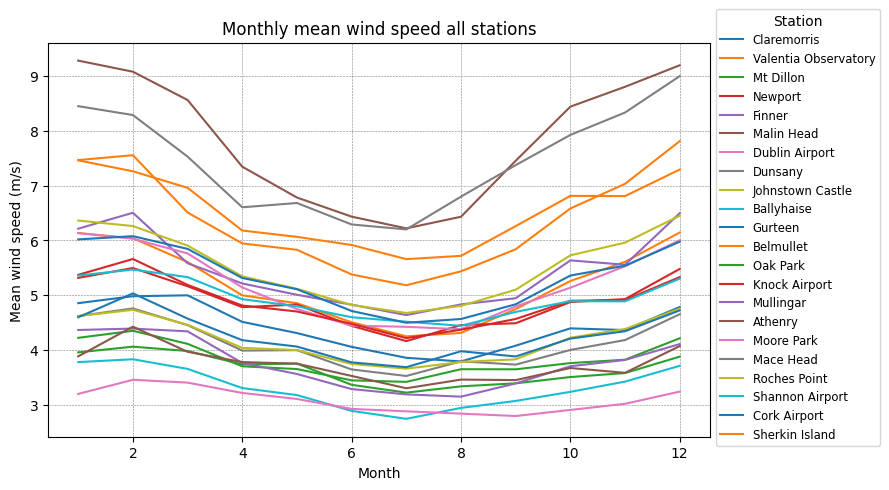

In [4]:
DATADIR = Path("stationdata")

plt.figure(figsize=(9, 5))
for file in DATADIR.glob("*.csv"):
    df = pd.read_csv(file,low_memory=False)

    # Mean wind speed monthly
    monthly_wdsp = df.groupby("month")["wdsp_ms"].mean()
    
    # Use the file name (without extension) as the label
    monthly_wdsp.plot(label=file.stem)

plt.xlabel("Month")
plt.ylabel("Mean wind speed (m/s)")
plt.title("Monthly mean wind speed all stations")
plt.legend(title="Station", fontsize='small',bbox_to_anchor=(1,1.1))
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.4)

# put a copy of the image of the plot (.png file) into the `plot` folder in the root of my repository
plt.tight_layout() # to fit the plot in the png image
plt.savefig(f"plot/Wind speed study - monthly mean windspeed.png")

plt.show()

This plot displays the long-term average monthly mean wind speed at 22 weather stations. 

All stations follow a very similar seasonal pattern. Strongest winds occur in the winter months (December–February), and the wind speed reaches the minimum in the summer months (June–August). 

The wind speed is highest and the seasonal variation is the greatest at Valentia Observatory, Belmullet, Malin Head, Mace Head, and Sherkin Island (western coastal and northern stations). Often the wind speed is 7-9+ m/s in winter and 5-6+ m/s in summer, which represents a difference of 1-2 m/s. 

The western/ midland stations like Shannon Airport, Roches Point, and Johnstown Castle represent moderate windspeed and moderate seasonal variation. 

The wind speed is lowest and the seasonal variation is low at Dunsany, Oak Park, Moore Park, Athenry, and Mullingar (inland and eastern stations), mostly 3-5 m/s year-round, with winter max wind speed rarely exceeding 5 m/s.

##### - Hourly wind speed all stations

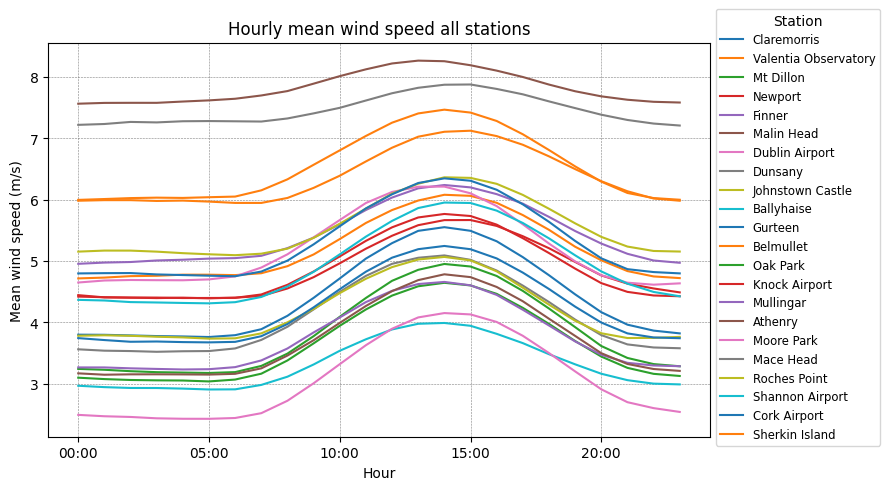

In [5]:
DATADIR = Path("stationdata")

plt.figure(figsize=(9, 5))
for file in DATADIR.glob("*.csv"):
    df = pd.read_csv(file,low_memory=False)
    
    # Mean wind speed monthly
    hourly_wdsp = df.groupby("hour")["wdsp_ms"].mean()
    
    # Use the file name (without extension) as the label
    hourly_wdsp.plot(label=file.stem)

plt.xlabel("Hour")
plt.ylabel("Mean wind speed (m/s)")
plt.title("Hourly mean wind speed all stations")
plt.legend(title="Station", fontsize='small',bbox_to_anchor=(1,1.1))
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.4)

# put a copy of the image of the plot (.png file) into the `plot` folder in the root of my repository
plt.tight_layout() # to fit the plot in the png image
plt.savefig(f"plot/Wind speed study - hourly mean windspeed.png")

plt.show()

This chart shows the typical 24-hour variation in mean wind speed for 22 stations.

The pattern is very consistent across the country: 
- Minimum wind speeds occur in the early morning hours (usually 3–7 am). 
- Maximum wind speeds occur in the mid-to-late afternoon (typically 2–4 pm).
- Wind speeds then steady decline through the evening and night.

The difference between daily min and max is generally 1–2.5 m/s: 
- largest (2-2.5 m/s) at exposed coastal and western stations; also, at these stations the peak is earlier than in other locations.
- moderate (1.2-1.8 m/s) at midland and eastern stations, 
- smallest (0.8-1.3 m/s) at most inland locations

##### - Wind power density all stations

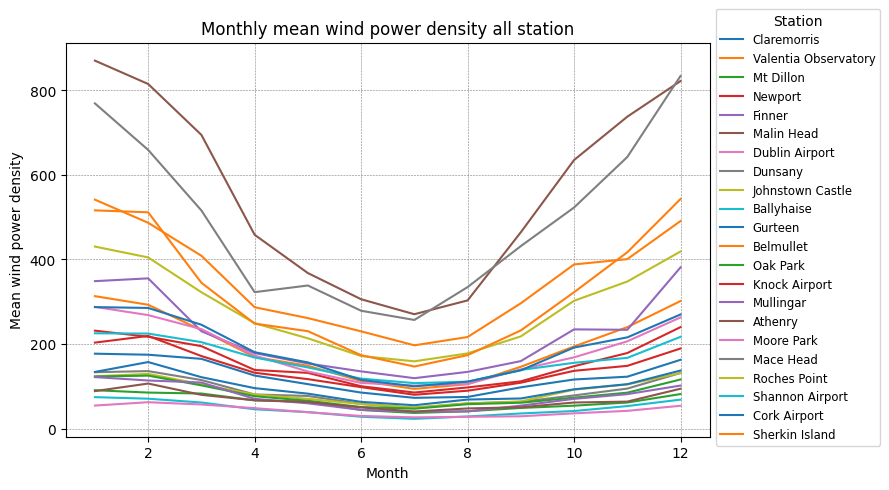

In [6]:
DATADIR = Path("stationdata")

plt.figure(figsize=(9, 5))
for file in DATADIR.glob("*.csv"):
    df = pd.read_csv(file,low_memory=False)
    
    # Mean wind speed monthly
    monthly_power = df.groupby("month")["power"].mean()
    
    # Use the file name (without extension) as the label
    monthly_power.plot(label=file.stem)

plt.xlabel("Month")
plt.ylabel("Mean wind power density")
plt.title("Monthly mean wind power density all station")
plt.legend(title="Station", fontsize='small',bbox_to_anchor=(1,1.1))
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.4)

# put a copy of the image of the plot (.png file) into the `plot` folder in the root of my repository
plt.tight_layout() # to fit the plot in the png image
plt.savefig(f"plot/Wind density study - monthly mean wind power density.png")

plt.show()

This plot displays the long-term average monthly wind power density (W/m²) for 22 studied stations across Ireland.

Wind power density is proportional to the cube of wind speed (P x v³), so small differences in mean wind speed translate into very large differences in available power — this explains why the ranking and seasonal contrast appear dramatically amplified compared to the mean wind speed plot.

We observe here an extreme seasonal variation: Winter months (Dec–Feb) deliver 3–10 times more power density than summer months (Jun–Aug) at the best sites.

Constrast between locations:

- Exposed west coast → 700–850+ W/m² in winter vs. 200–350 W/m² in summer
- Inland/sheltered → 80–150 W/m² winter vs. 30–70 W/m² summer

##### - Hourly wind power all stations

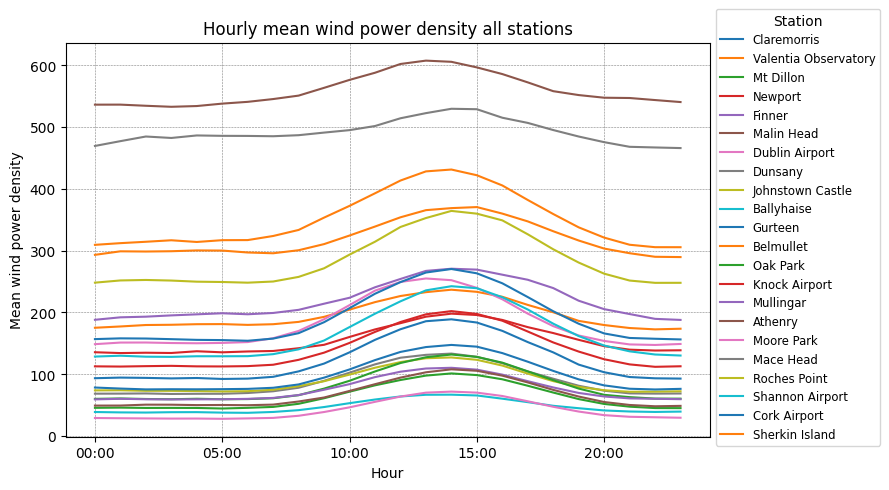

In [7]:
DATADIR = Path("stationdata")

plt.figure(figsize=(9, 5))
for file in DATADIR.glob("*.csv"):
    df = pd.read_csv(file,low_memory=False)
    
    # Mean wind speed monthly
    hourly_power = df.groupby("hour")["power"].mean()
    
    # Use the file name (without extension) as the label
    hourly_power.plot(label=file.stem)

plt.xlabel("Hour")
plt.ylabel("Mean wind power density")
plt.title("Hourly mean wind power density all stations")
plt.legend(title="Station", fontsize='small',bbox_to_anchor=(1,1.1))
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.4)

# put a copy of the image of the plot (.png file) into the `plot` folder in the root of my repository
plt.tight_layout() # to fit the plot in the png image
plt.savefig(f"plot/Wind density study - hourly mean wind power density.png")

plt.show()

The chart shows long-term average hourly wind power density in W/m² throughout the 24-hour day for all stations studied.

Because wind power density scales with the cube of wind speed (P x v³), the diurnal pattern is much more pronounced than in the mean wind speed plot — even modest increases in afternoon wind speed create large increases in available power.

Very strong 24-hour cycle is observed at all sites.
- Minimum power density: early morning (usually 04:00–07:00)
- Maximum power density: mid-afternoon (typically 13:00–16:00, peaking around 14:00–15:00)

Afternoon peak is 1.5–3.0 times higher than the early-morning minimum at most stations (far more extreme than the ~1.2–2.5× range seen in wind speed itself).

## 4/ Analysis of wind turbine operating hours


It’s not only the speed, but more importantly the consistency of wind that produces the most power. Wind turbines operate within specific speed ranges: 
- Cut-in speed: they start generating power around 3–4 m/s.
- Rated speed (Max Output): Around 12–14 m/s, where turbines generate their maximum power.
- Cut-out speed (Shutdown): Above 25 m/s to protect the turbine from severe wind damage.
- Optimal Range: Generally considered to be between 4 m/s and 12 m/s for efficient power generation, though turbines are designed to operate up to their cut-out speed.

##### Yearly operating hours and optimal hours for each station

The code below returns bar charts showing how many hours per year a wind turbine could operate, and how many of those hours are optimal for power production in multiple stations. Each CSV file produces one plot, saved as a PNG image.

Ref for plot: 

https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html

/tmp/ipykernel_126541/3353385270.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(8, 3))


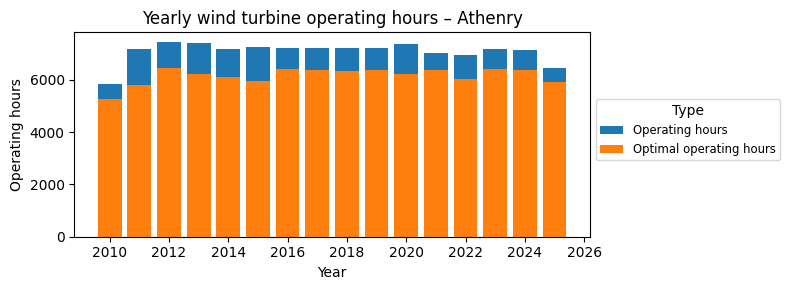

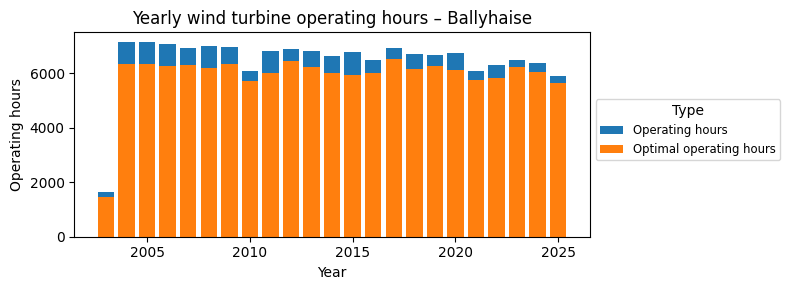

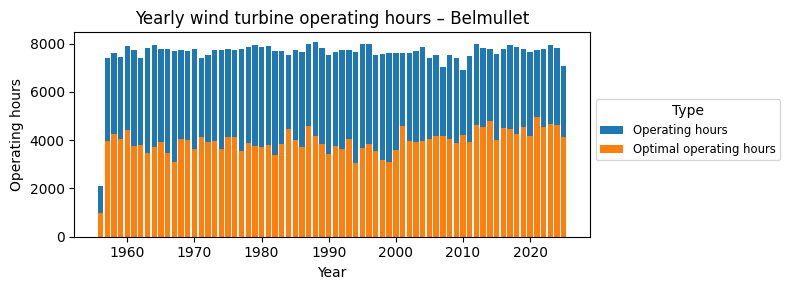

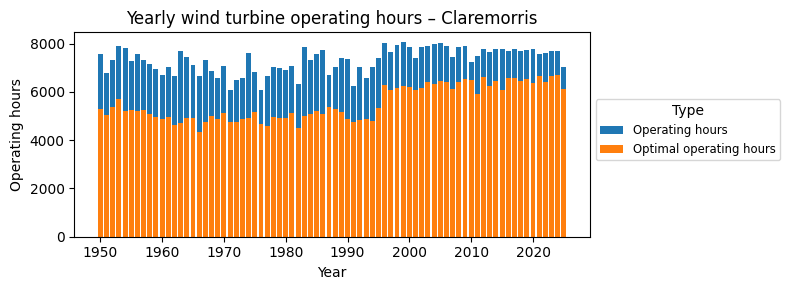

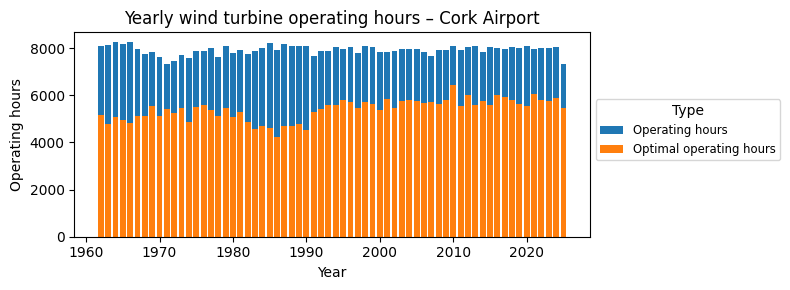

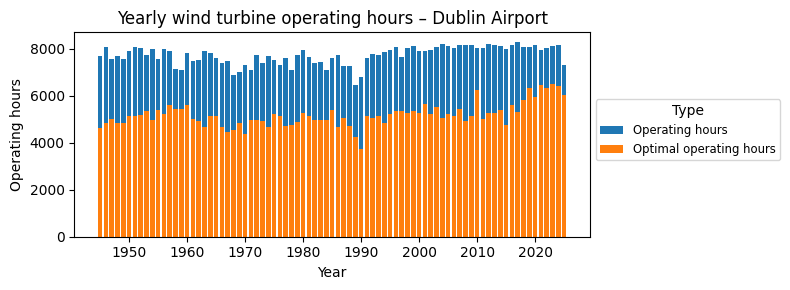

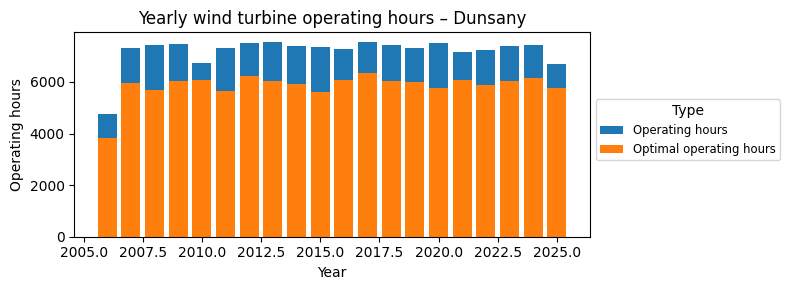

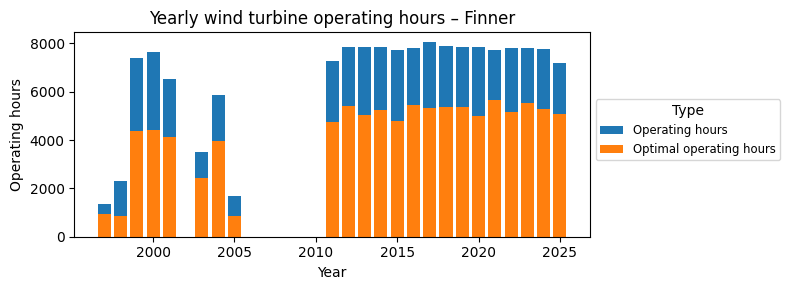

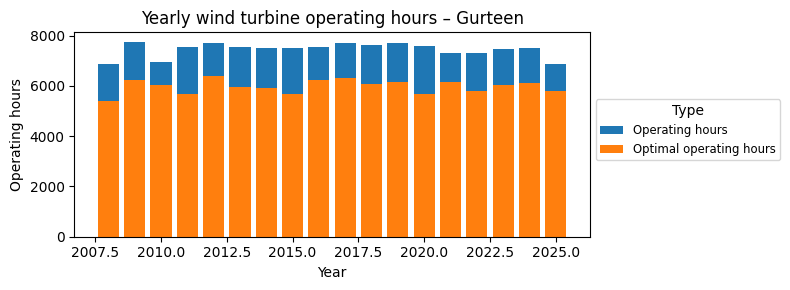

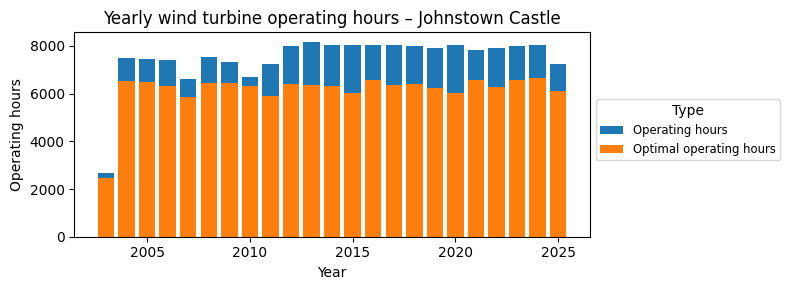

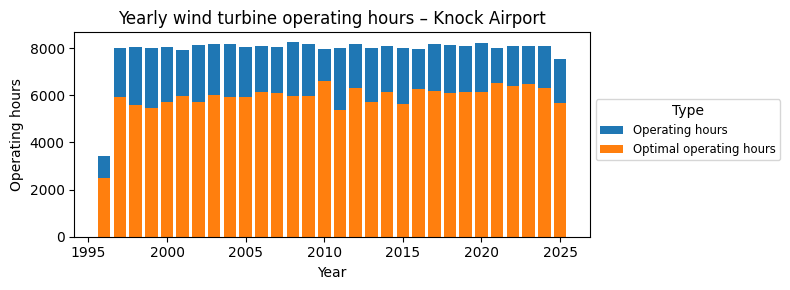

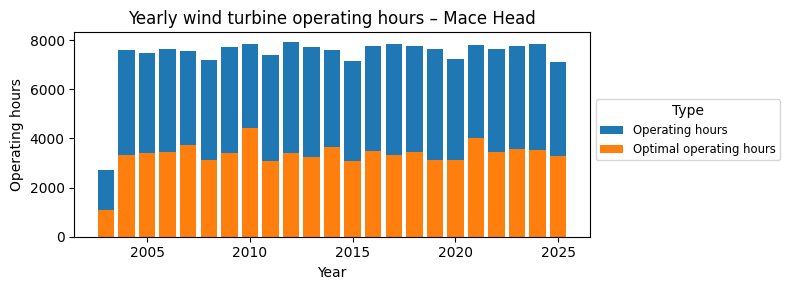

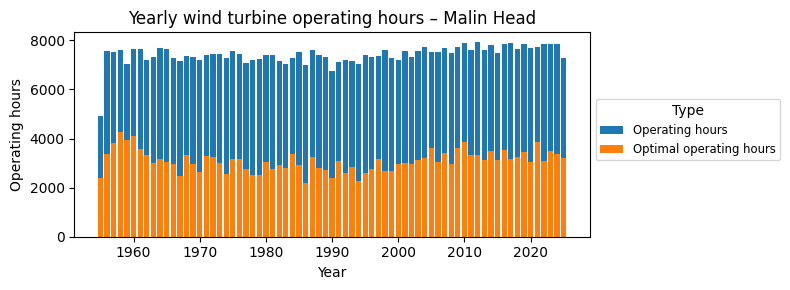

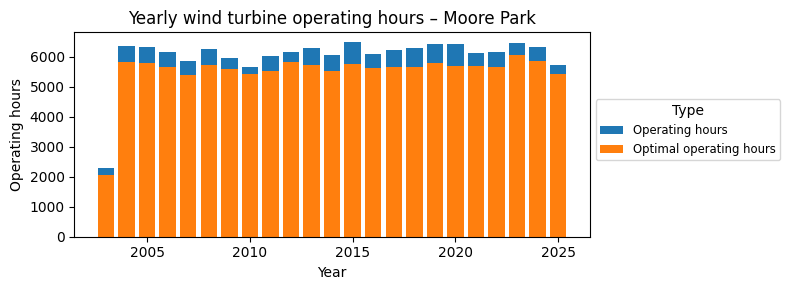

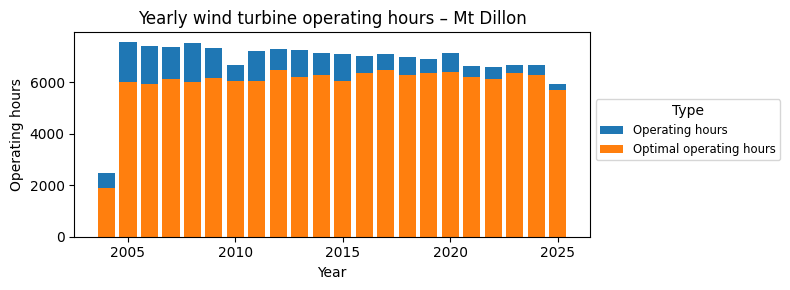

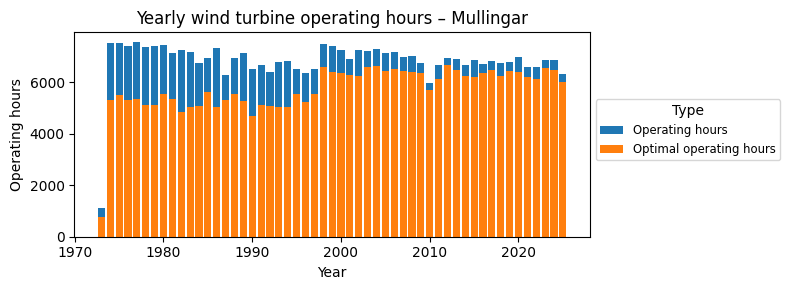

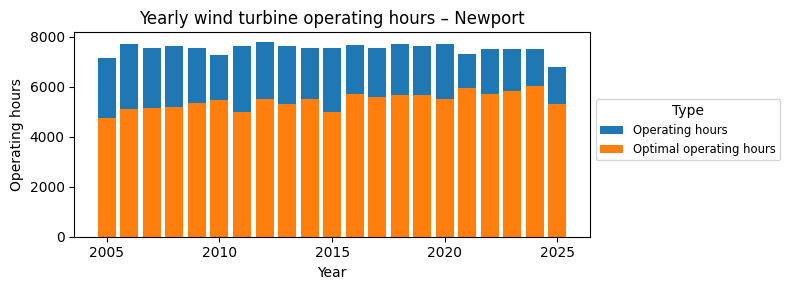

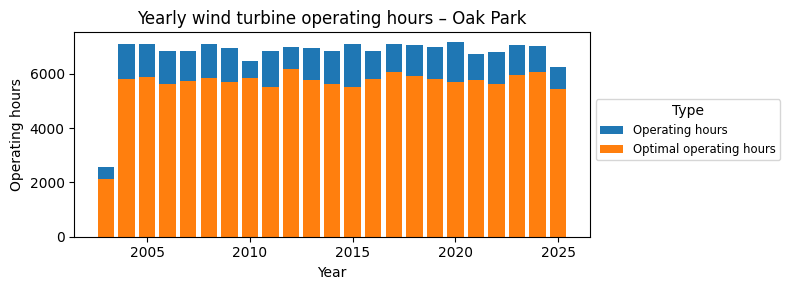

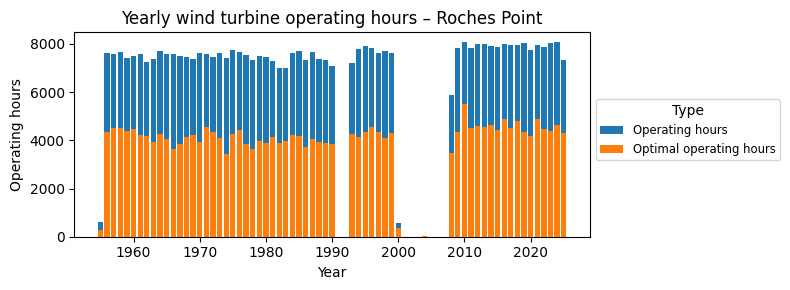

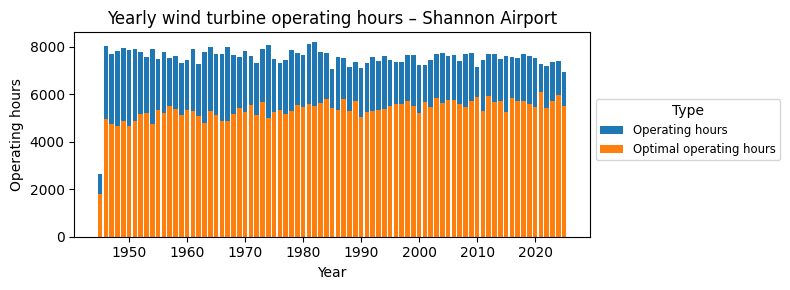

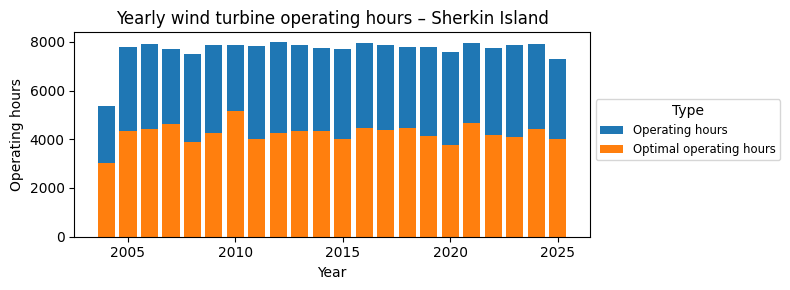

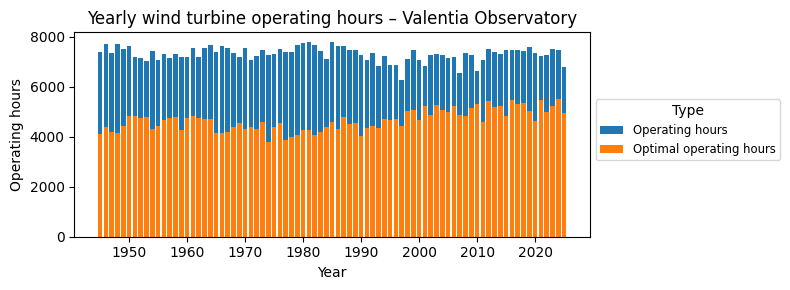

In [8]:
# Define the wind range
cut_in = 4
optimum = 12   
cut_out = 25

DATADIR = Path("stationdata")

# Read file in alphabet order
for file in sorted (DATADIR.glob("*.csv")):
    df = pd.read_csv(file,low_memory=False)
    
    # Study wind range for wind turbines operation
    df["operating"] = (df["wdsp"] >= cut_in) & (df["wdsp"] <= cut_out)
    df["optimal"]   = (df["wdsp"] >= cut_in) & (df["wdsp"] <= optimum)

    # Number of hours of operation in total per year
    yearly_operating = df.groupby("year")["operating"].sum()
    # Number of hours of optimal production in total per year
    yearly_optimal= df.groupby("year")["optimal"].sum()

    fig, ax = plt.subplots(figsize=(8, 3))

    # Bar plot 'operating hours'
    bars1 = ax.bar(yearly_operating.index, yearly_operating.values, label="Operating hours")

    # Bar plot 'optimal hours'
    bars2 = ax.bar(yearly_optimal.index, yearly_optimal.values, label="Optimal operating hours")

    station_name = file.stem.title()

    ax.set_xlabel("Year")
    ax.set_ylabel("Operating hours")
    ax.set_title(f"Yearly wind turbine operating hours – {station_name}")

    # value labels
    #ax.bar_label(bars1, fontsize=8, padding=3)
    #ax.bar_label(bars2, fontsize=8, padding=3)

    # legend
    ax.legend(title="Type", fontsize="small",bbox_to_anchor=(1,0.7))

    # put a copy of the image of the plot (.png file) into the `plot` folder in the root of my repository
    plt.tight_layout() # to fit the plot in the png image
    plt.savefig(f"plot/Yearly wind operation hours {station_name}.png")

plt.show()

These bar charts provide a clear and useful yearly summary of wind turbine operating conditions based on hourly wind speed data from all stations.

The main observations we can make based on the plots:

- Total operating hours (blue bars) shows how many hours per year the wind speed was within the classic wind turbine operating range (4–25 m/s).

- Optimal range hours (orange bars) shows hours in the optimal range 4-12 m/s. This typically ranges between 5000–6500 hours/year depending on the station and year, which represents roughly 64–83% of total operating time in most Irish locations.

Common patterns seen across stations: Very good wind years in general with high total operating hours (6000-8000 hours) and high optimal hours frequently. These stations have reasonably good wind resources, with 68-91% of hours suitable for generation and 57-74% of all hours in the optimal range, which represents quite a notable level of year-to-year variability.

At coastal and western stations (Belmullet, Valencia Observatory, Mace Head, Sherkin Island, Malin Head) the optimal range hours are low compared to the majority of stations.

On the contrary, inland and sheltered stations (Dunsany, Oak Park, Moore Park, Athenry, Mullingar) display a large number of operating hours and optimal range hours. 

This observation reinforces the conclusion that it is the consistency of wind that produces the most wind power, not the speed. 

Claremorris and Finner represent high variation in optimal range hours, which might not be suitable for wind farms. 

Note: At Roches Point, data is missing for the years 1991, 1992, and 2000-2007. However, from the years that are recorded, the operating hours and optimal range hours are consistent. 

#### Monthly operating hours and optimal hours for each station

The code below returns bar charts showing how many hours per month a wind turbine could operate, and how many of those hours are optimal for power production in multiple stations. Each CSV file produces one plot, saved as a PNG image.

/tmp/ipykernel_126541/2709903644.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(8, 3))


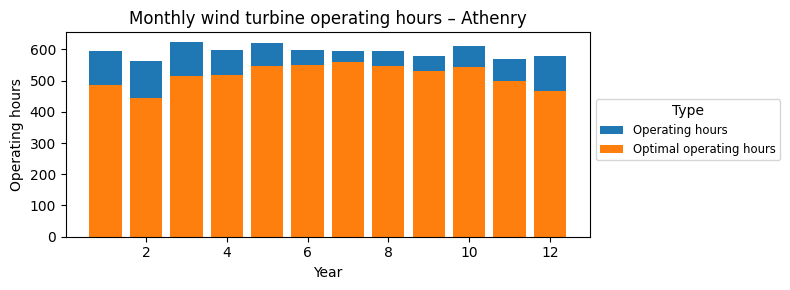

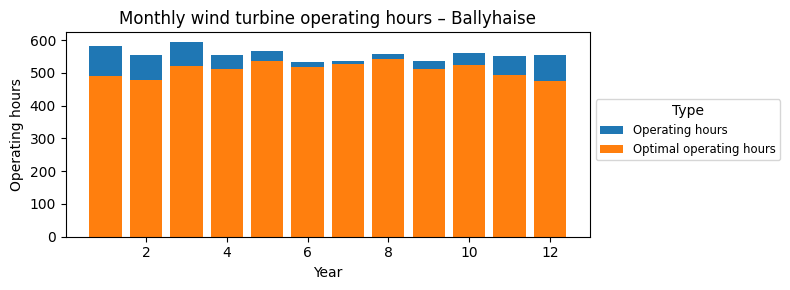

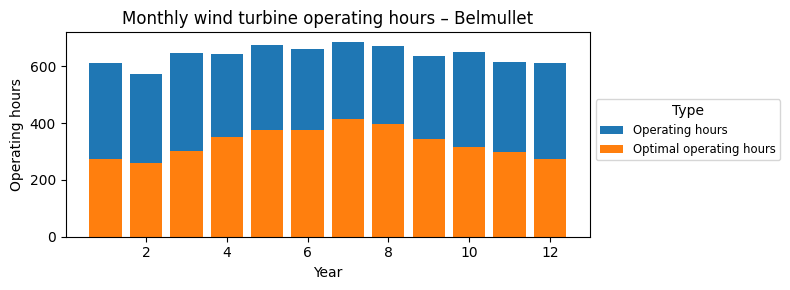

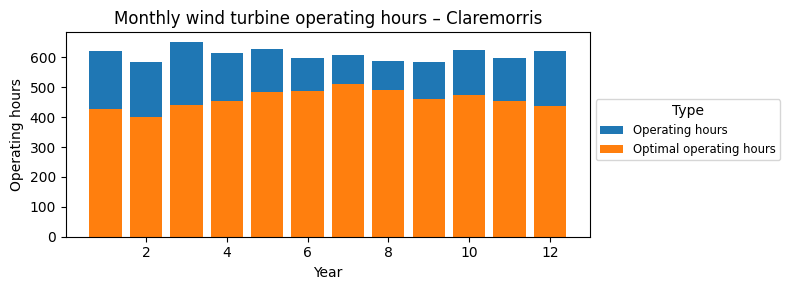

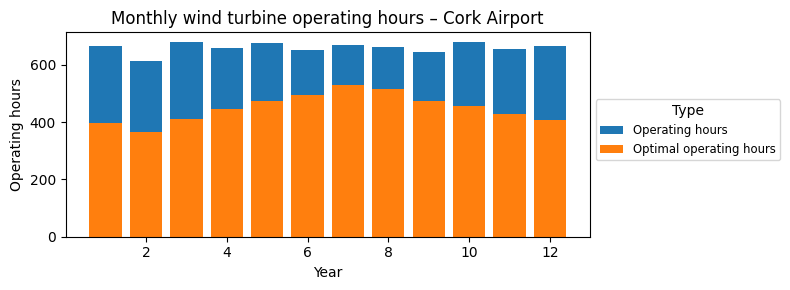

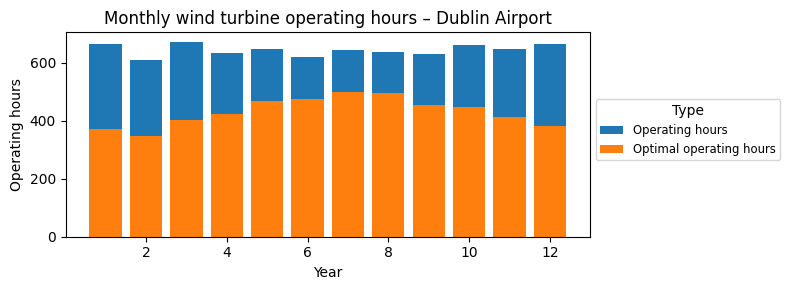

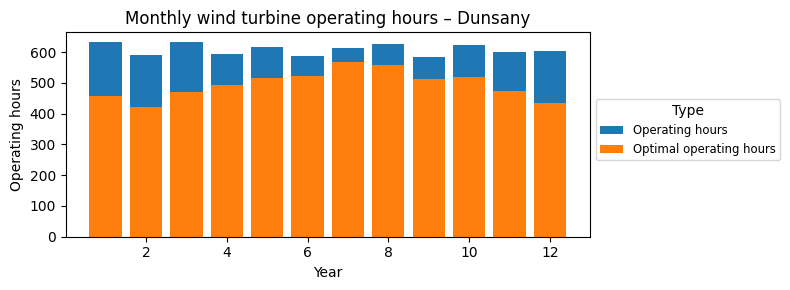

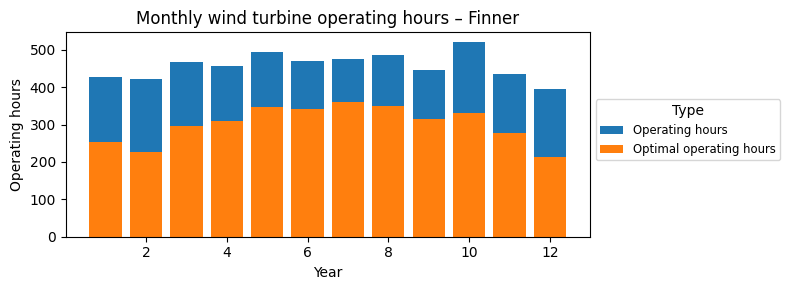

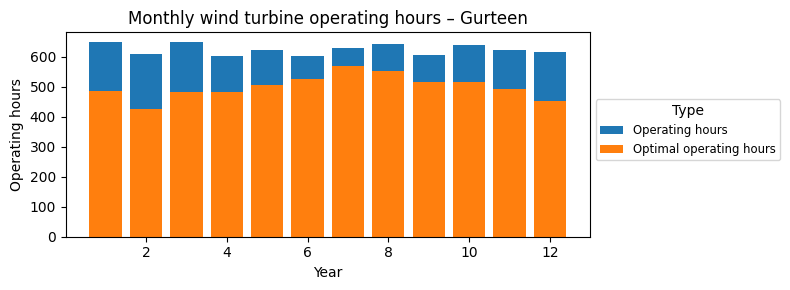

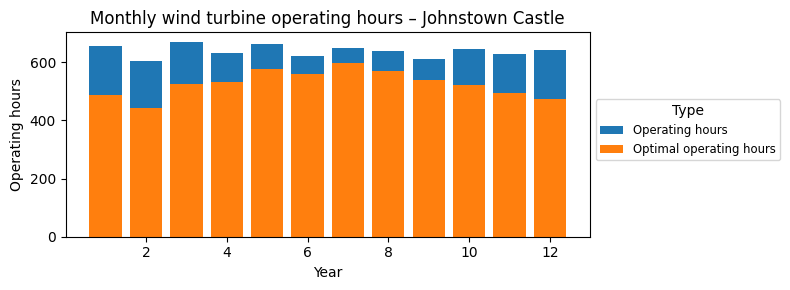

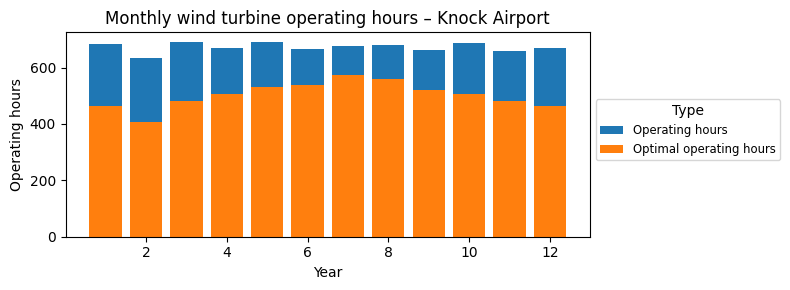

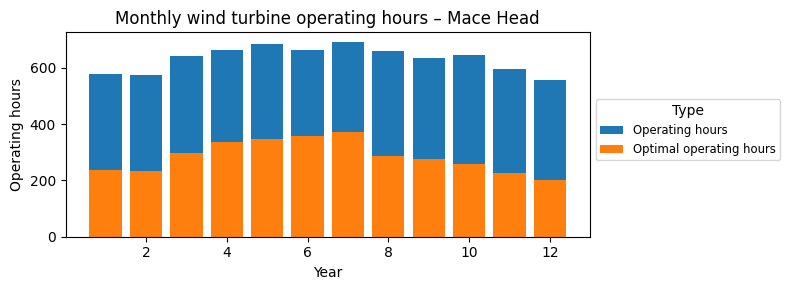

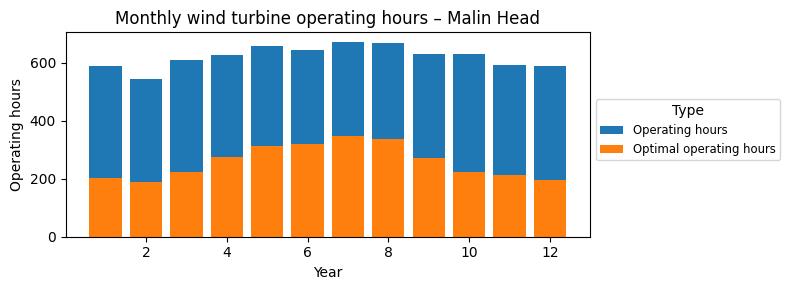

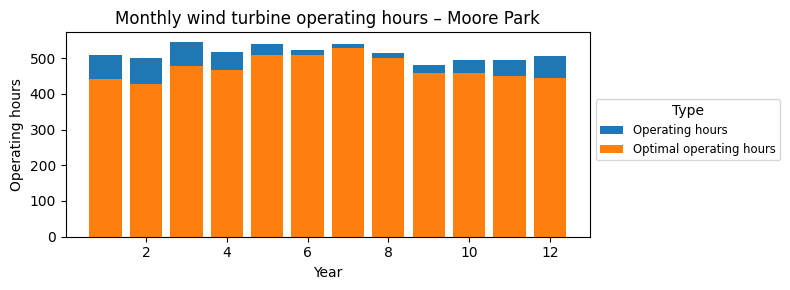

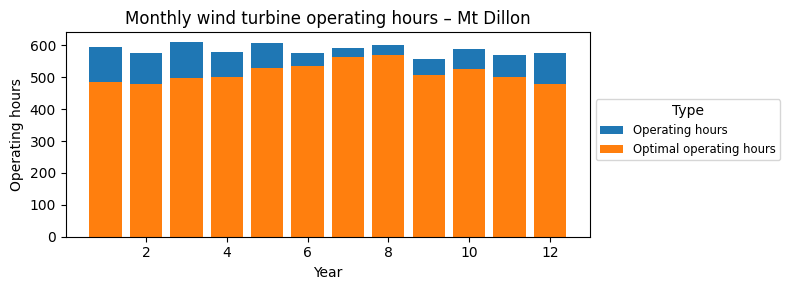

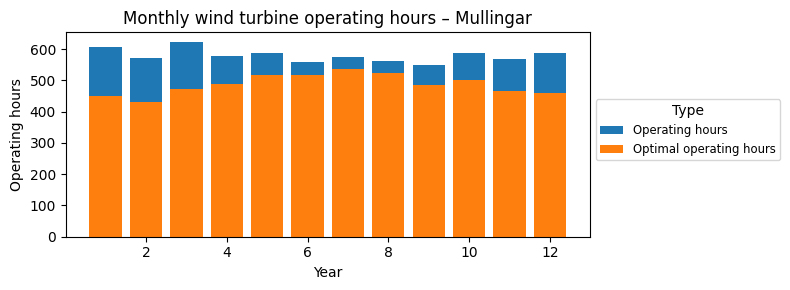

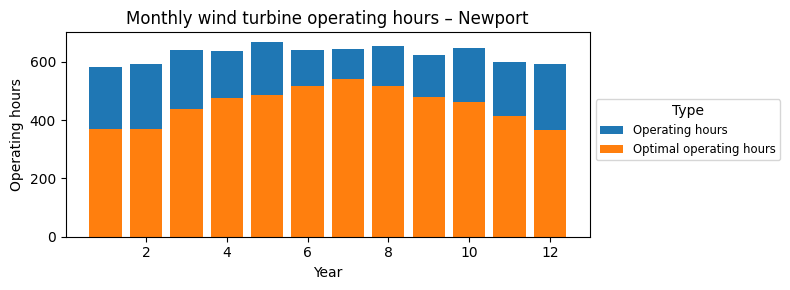

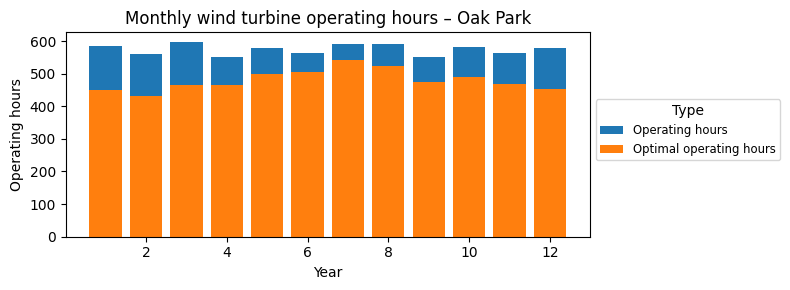

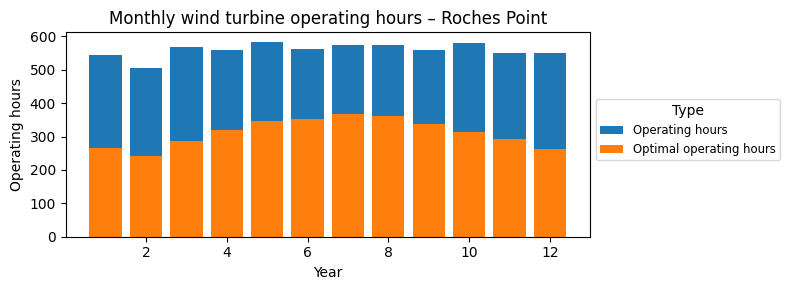

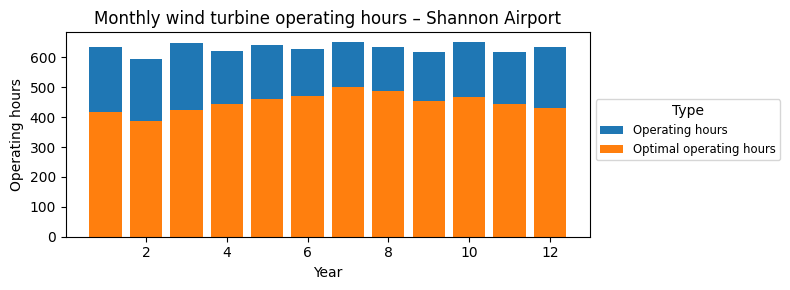

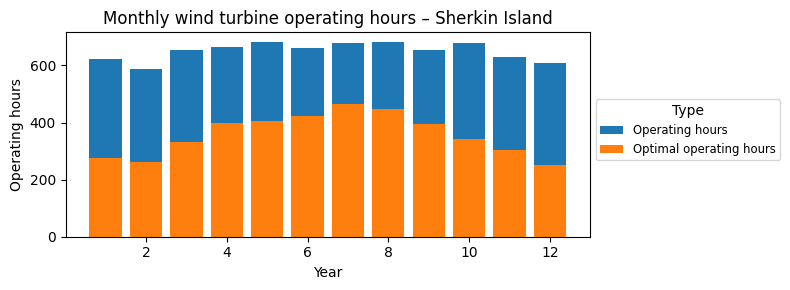

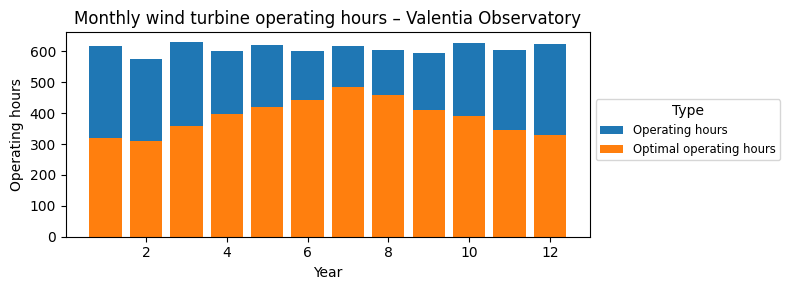

In [9]:
# Define the wind range
cut_in = 4
optimum = 12    
cut_out = 25

DATADIR = Path("stationdata")

# Read file in alphabet order
for file in sorted (DATADIR.glob("*.csv")):
    df = pd.read_csv(file,low_memory=False)
    
    # Study wind range for wind turbines operation
    df["operating"] = (df["wdsp"] >= cut_in) & (df["wdsp"] <= cut_out)
    df["optimal"]   = (df["wdsp"] >= cut_in) & (df["wdsp"] <= optimum)

    # Number of hours of operation on average per month
    monthly_operating = (df.groupby(["year", "month"])["operating"].sum().groupby("month").mean())
    # Number of hours of optimal production on average per month
    monthly_optimal = (df.groupby(["year", "month"])["optimal"].sum().groupby("month").mean())

    fig, ax = plt.subplots(figsize=(8, 3))

    # Bar plot 'operating hours'
    bars1 = ax.bar(monthly_operating.index, monthly_operating.values, label="Operating hours")
    # Bar plot 'optimal hours'
    bars2 = ax.bar(monthly_optimal.index, monthly_optimal.values, label="Optimal operating hours")

    station_name = file.stem.title()

    ax.set_xlabel("Year")
    ax.set_ylabel("Operating hours")
    ax.set_title(f"Monthly wind turbine operating hours – {station_name}")

    # value labels
    #ax.bar_label(bars1, fontsize=8, padding=3)
    #ax.bar_label(bars2, fontsize=8, padding=3)

    # legend
    ax.legend(title="Type", fontsize="small",bbox_to_anchor=(1,0.7))
    
    # put a copy of the image of the plot (.png file) into the `plot` folder in the root of my repository
    plt.tight_layout() # to fit the plot in the png image
    plt.savefig(f"plot/Monthly operation hours - {station_name}.png")

plt.show()

These stacked bar plots show monthly wind turbine operating hours at 22 stations studied. 

The overall pattern is the turbines operate 500-700 hours per month depending on the location (69-97% of the hours), which is very high total operating hours. 

We observe a peak in summer months (June-August) in optimal hours at almost all stations. The peak is very clear in Belmullet, Mace Head, Malin Head, Newport, Sherkin Island and Valentia Observatory. These western and coastal stations have much more wind but the wind is so strong that it's not in the production range.

We also notice much of the total production hours comes from optimal hours at Athenry, Ballyhaise, Gurteen, Johnstown Castle, Moore Park, Mt Dillon, Mullingar and Oak Park. They are more inland and sheltered, so they produce slightly fewer total hours but much better quality. The peak of optimal hours is not so clear, it means there is less production hours variation. Which probably makes them the best locations for wind farms.

Other stations fall in between those two groups, and they are also good for wind farms.

## 5/ Study the wind speed trend

For each station, the code below computes the monthly mean wind speed, computes a linear regression to analyse long-term trends. It then scatter plots the monthly means together with the red trend line and displays key regression statistics (slope, p-value, and R²) for each station.

/tmp/ipykernel_126541/3841418300.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(9,4))


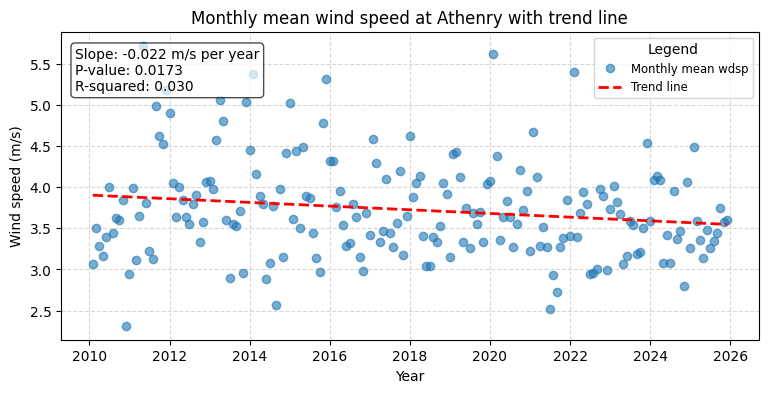

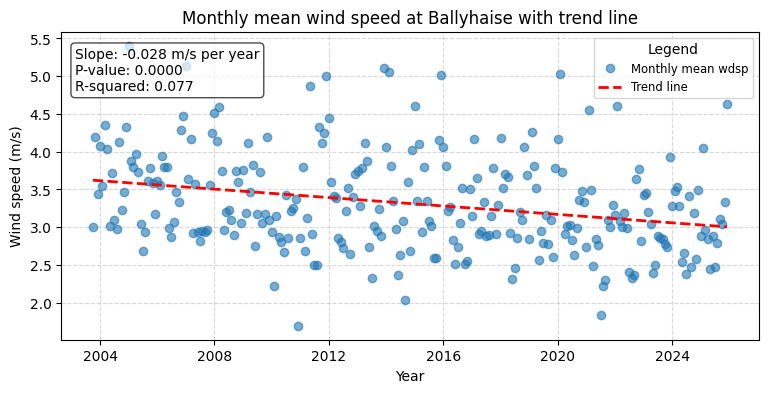

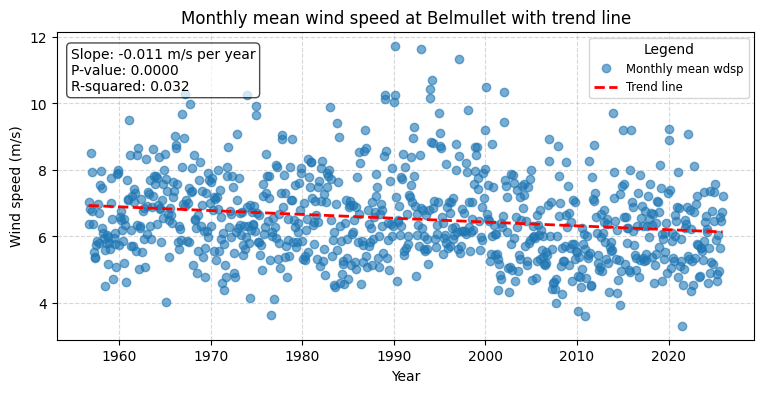

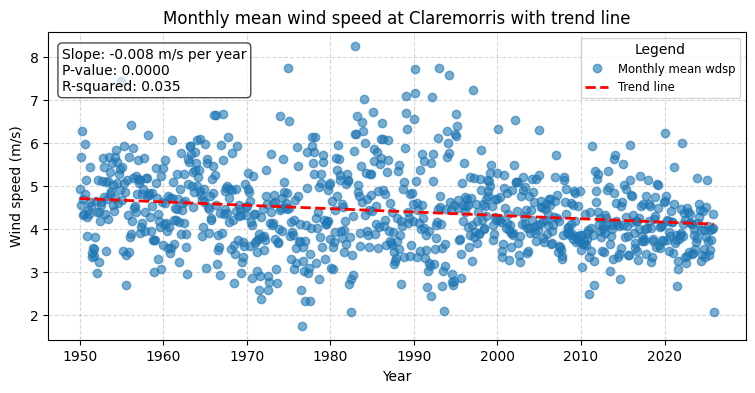

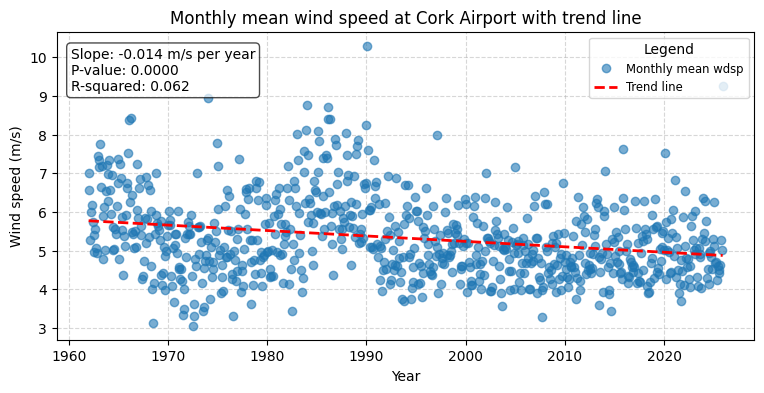

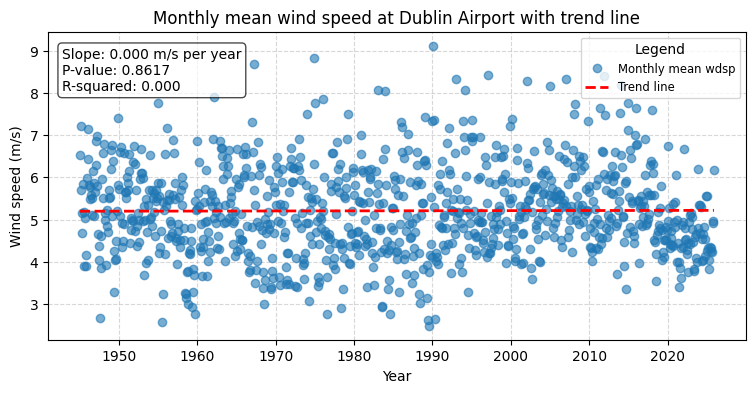

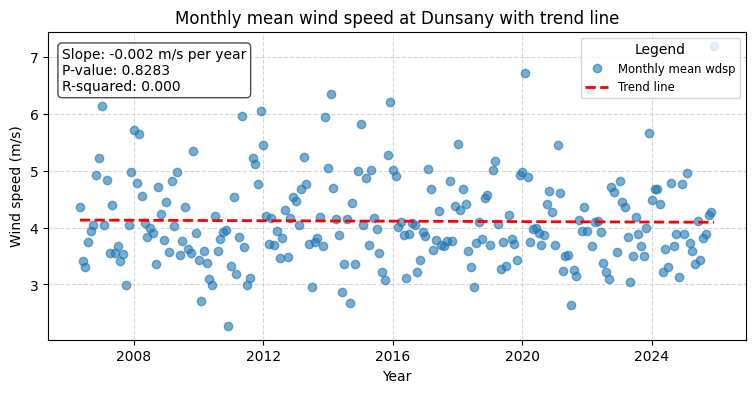

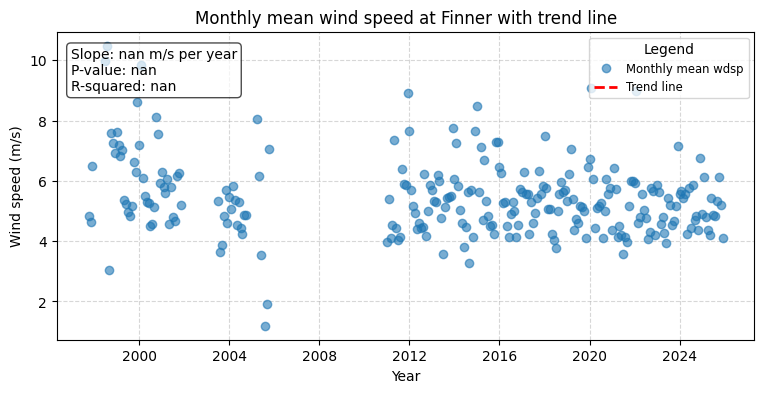

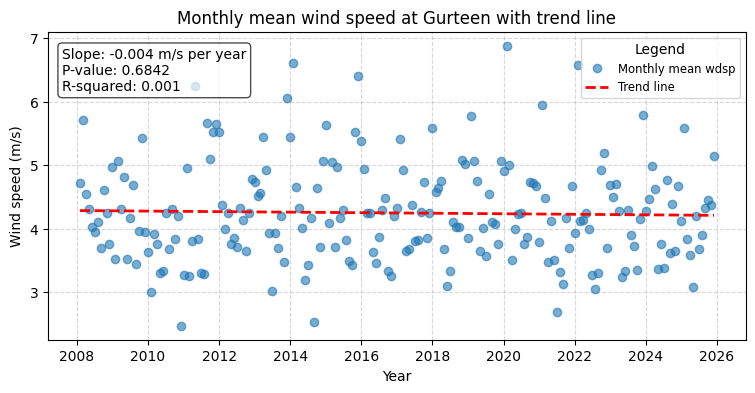

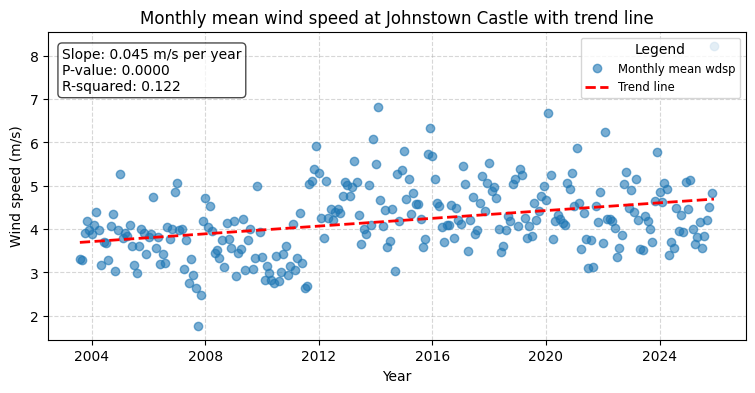

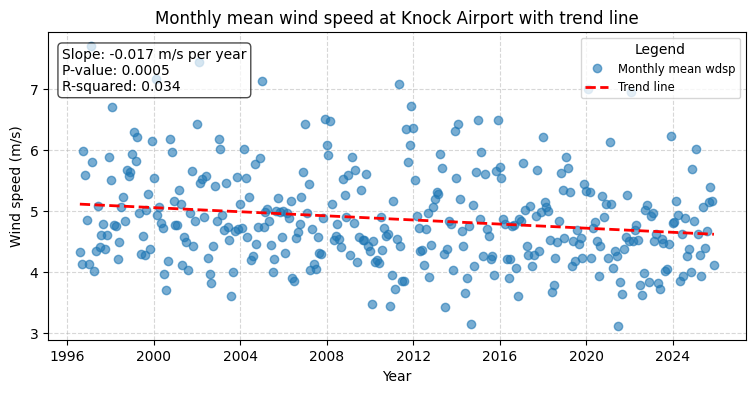

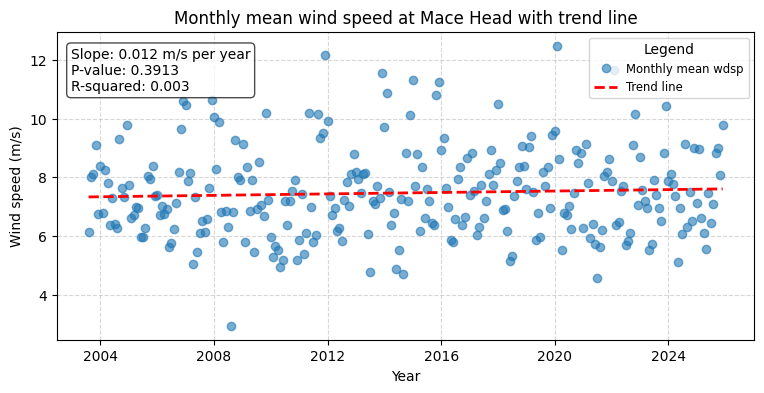

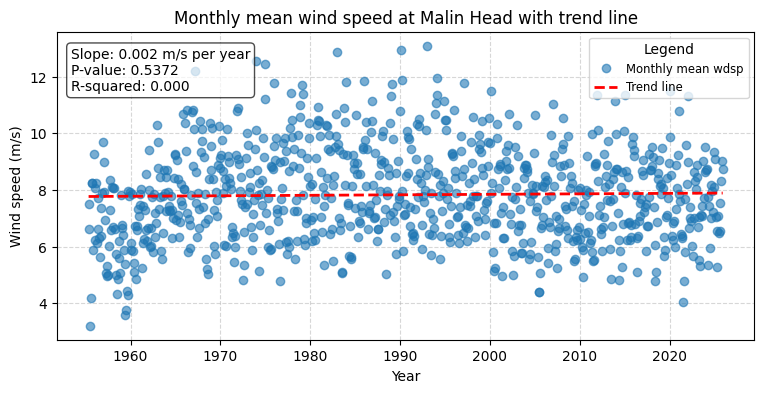

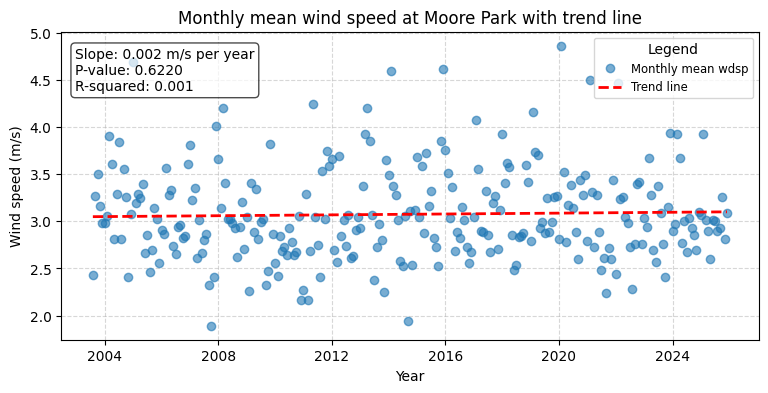

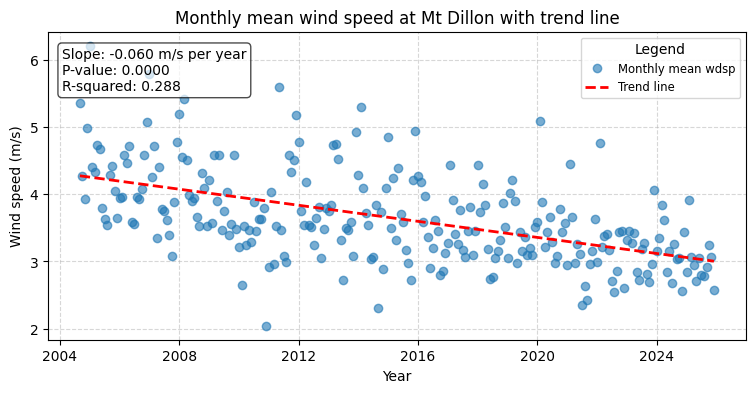

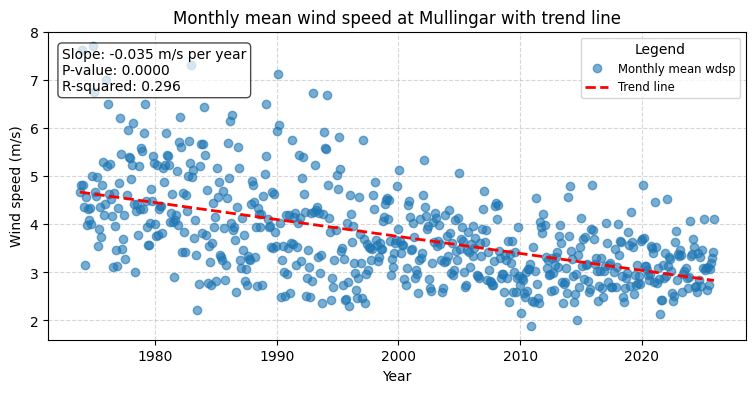

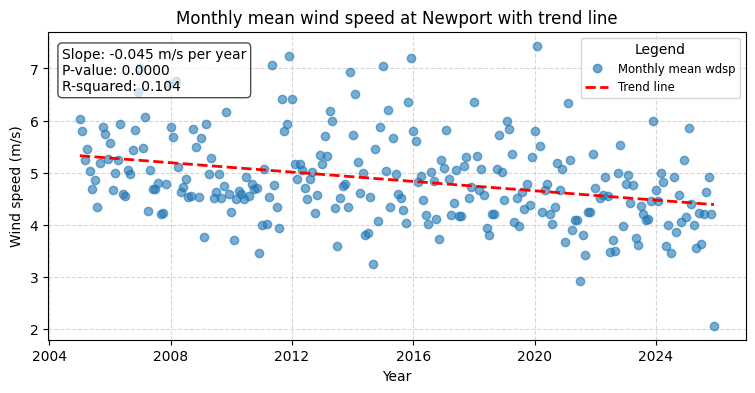

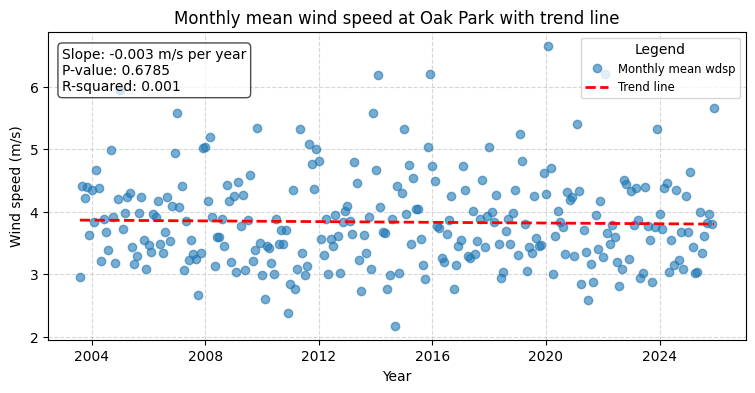

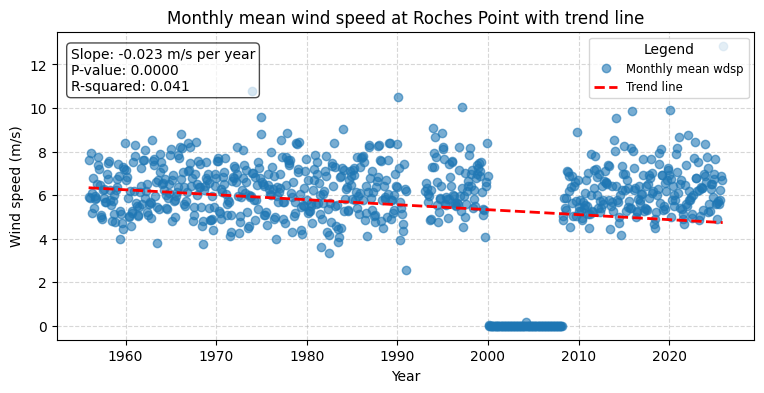

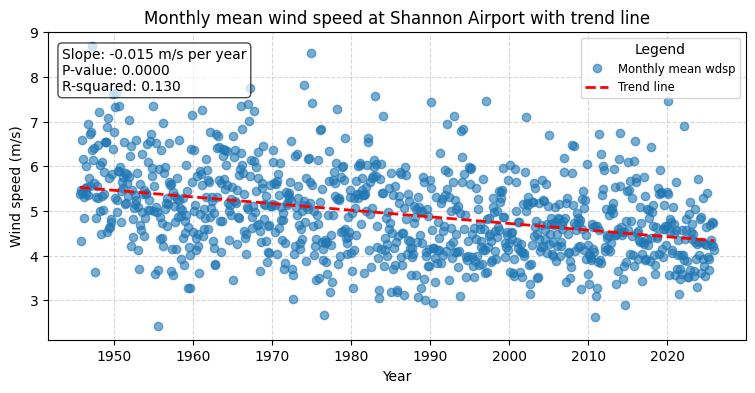

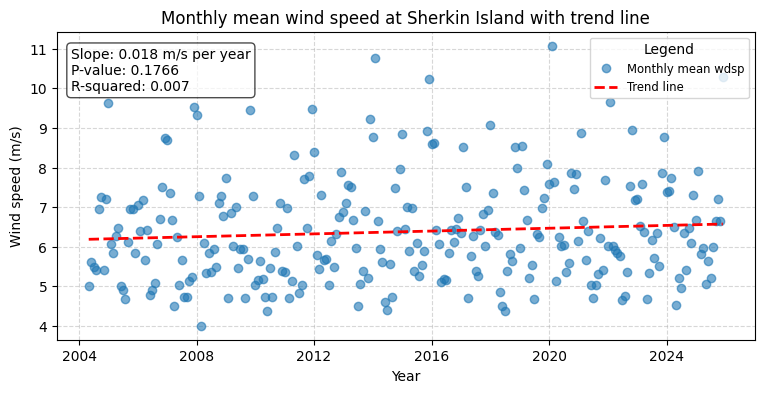

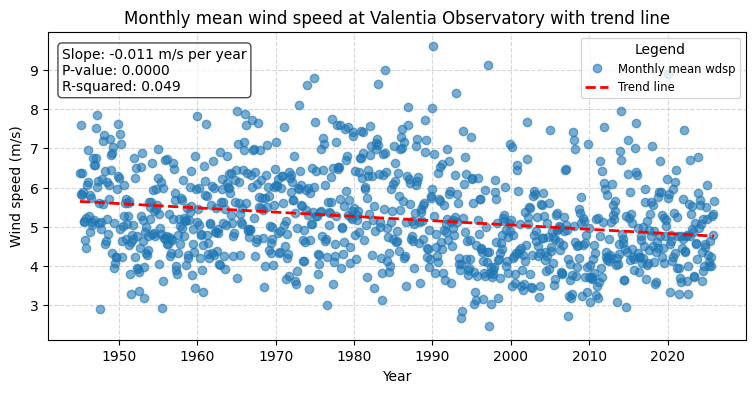

In [10]:
DATADIR = Path("stationdata")

# Read file
for file in sorted (DATADIR.glob("*.csv")):
    df = pd.read_csv(file,low_memory=False)

    # Calculate monthly mean wind speed 
    df["yearmonth"] = pd.to_datetime(df["yearmonth"], format="%Y-%m")
    monthly_mean = df.groupby("yearmonth")["wdsp_ms"].mean()

    # Convert datetime to numeric decimal years for regression
    X_numeric = monthly_mean.index.year + (monthly_mean.index.month - 1)/12
    Y = monthly_mean.values

    # Compute linear regression trend
    slope, intercept, r_value, p_value, std_err = linregress(X_numeric, Y)
    trend = intercept + slope * X_numeric

    #print(f"Slope: {slope:.3f} m/s per year")
    #print(f"P-value: {p_value:.4f}, R-squared: {r_value**2:.3f}")

    # Plot
    fig, ax = plt.subplots(figsize=(9,4))

    station_name = file.stem.title()

    # Monthly mean wind speed
    ax.plot(monthly_mean.index, Y, marker='o', linestyle='None', label="Monthly mean wdsp",alpha = 0.6)

    # Trend line
    ax.plot(monthly_mean.index, trend, linestyle='--', color='red', linewidth=2, label="Trend line")

    # Labels and title
    ax.set_xlabel("Year")
    ax.set_ylabel("Wind speed (m/s)")
    ax.set_title(f"Monthly mean wind speed at {station_name} with trend line")
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(title="Legend", fontsize='small',loc="upper right")

    # Add regression details on the plot
    ax.text(0.02, 0.95, f"Slope: {slope:.3f} m/s per year\nP-value: {p_value:.4f}\nR-squared: {r_value**2:.3f}", 
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.7))

# put a copy of the image of the plot (.png file) into the `plot` folder in the root of my repository
#plt.savefig(f"plot/Trend study - monthly mean wind speed.png")

plt.show()

Three groups of stations are observed here: 

- Johnstown Castle shows a positive trend; there is more and more wind at this station.

- Ballyhaise, Belmullet, Claremorris, Cork Airport, Knock Airport, Mt Dillon, Mullingar, Newport, Valentia Observatory display negative trends. There is less and less wind at these stations, and the trend line angle is greater for Mt Dillon, Mullingar and VAlentia Observatory.

- Athenry, Dublin Airport, Dunsany, Gurteen, Mace Head, Malin Head, Moore Park, Oak Park and Sherkin Island don't really have a trend, or the quantity of wind is quite stable, which should be considered a positive characteristic for stable wind energy production.


## 6/ Is there any other weather metric worth analysing (eg rain, temp)

### Correlations: rain x wind speed and temperature x wind speed

For each station, the code below calculates the Pearson correlation coefficient between wind speed (wdsp_ms) and rainfall, and between wind speed and temperature, then collects these correlations along with the station name into a results list. It shows us how wind speed is related to rainfall and temperature across all stations.

In [2]:
DATADIR = Path("stationdata")

results = []

for file in sorted(DATADIR.glob("*.csv")):
    df6 = pd.read_csv(file,low_memory=False)

    # convert 'rain' to numeric
    df6["rain"] = pd.to_numeric(df6["rain"], errors="coerce")

    # convert 'temp' to numeric
    df6["temp"] = pd.to_numeric(df6["temp"], errors="coerce")
    
    station = file.stem

    # Correlations
    corr_wdsp_rain = df6["wdsp_ms"].corr(df6["rain"])
    corr_wdsp_temp = df6["wdsp_ms"].corr(df6["temp"])

    results.append({
        "station": station,
        "wdsp_vs_rain": corr_wdsp_rain,
        "wdsp_vs_temp": corr_wdsp_temp
    })

corr_df6 = pd.DataFrame(results)
corr_df6

station  wdsp_vs_rain  wdsp_vs_temp
0                Athenry      0.153478      0.182176
1             Ballyhaise      0.137872      0.118145
2              Belmullet      0.153218      0.070314
3            Claremorris      0.167860      0.120224
4           Cork Airport      0.226594      0.010607
5         Dublin Airport      0.067466     -0.017592
6               Dunsanny      0.104694      0.143121
7                 Finner      0.138534     -0.005061
8                Gurteen      0.142522      0.159272
9       Johnstown Castle      0.164500      0.055294
10         Knock Airport      0.187066      0.039264
11             Mace Head      0.150801     -0.037004
12            Malin Head      0.115249     -0.127861
13            Moore Park      0.184887      0.215984
14             Mt Dillon      0.146775      0.186871
15             Mullingar      0.142304      0.097428
16               Newport      0.165050      0.034231
17              Oak Park      0.140216      0.183758
18          Roches Point      0.183341     -0.033571
19       Shannon Airport      0.131881      0.096533
20        Sherkin Island      0.193781     -0.011891
21  Valentia Observatory      0.190919      0.045252

Wind speed shows a very weak correlation with rainfall and temperature, which is understandable as frequent hourly variation makes it hard to see the weather relationship. To better see the weather relationship we can try monthly correlation instead.

### Monthly correlation

The code below creates a table that quantifies how wind speed interacts with rainfall and temperature across different stations, providing slopes (magnitude of change), correlation strength (R-value), and confidence in the relationships (p-value).

In [ ]:
DATADIR = Path("stationdata")

results = []

for file in DATADIR.glob("*.csv"):
    df6_m = pd.read_csv(file,low_memory=False)

    # convert 'rain' to numeric
    df6_m["rain"] = pd.to_numeric(df6_m["rain"], errors="coerce")

    # convert 'temp' to numeric
    df6_m["temp"] = pd.to_numeric(df6_m["temp"], errors="coerce")
    
    station = file.stem

    # Correlations
    monthly = df6_m.groupby("yearmonth")[["wdsp_ms", "rain", "temp"]].mean()

    corr_month_wdsp_rain = monthly["wdsp_ms"].corr(monthly["rain"])
    corr_month_wdsp_temp = monthly["wdsp_ms"].corr(monthly["temp"])

    # Trend line
    slope_rain, intercept_rain, r_value_rain, p_value_rain, _ = linregress(monthly["rain"], monthly["wdsp_ms"])
    slope_temp, intercept_temp, r_value_temp, p_value_temp, _ = linregress(monthly["temp"], monthly["wdsp_ms"])

    results.append({
        "station": station,
        "wdsp_vs_rain": corr_month_wdsp_rain,
        "slope (rain x wdsp)": slope_rain,
        "intercept (rain x wdsp)": intercept_rain,
        "R-value (rain x wdsp)": r_value_rain,
        "P-value (rain x wdsp)": p_value_rain,
        "wdsp_vs_temp": corr_month_wdsp_temp,
        "intercept (temp x wdsp)": intercept_temp,
        "slope (temp x wdsp)": slope_temp,
        "R-value (temp x wdsp)": r_value_temp,
        "P-value (temp x wdsp)": p_value_temp,
    })

corr_df6_m = pd.DataFrame(results)
corr_df6_m["P-value (rain x wdsp)"] = corr_df6_m["P-value (rain x wdsp)"].map("{:.3f}".format)
corr_df6_m["P-value (temp x wdsp)"] = corr_df6_m["P-value (temp x wdsp)"].map("{:.3f}".format)
corr_df6_m

: 

##### Relationship between wind speed and rain is positive: 

Most relationships are statistically significant ((p < 0.01)

The correlation between wind speed and rain is mostly 0.3-0.6, which shows a moderate positive relationship — windier days tend to be more rainy. 

- The correlation is strongest at exposed western/southwestern coastal stations Malin Head, Sherkin Island (~0.60), Roches Point (~0.60), Belmullet (~0.56), and Knock (~0.54). 

- The correlation is weakest at Dublin Airport (~0.20), Athenry (~0.21), and Mullingar (~0.31). These stations are more inland and more sheltered stations in the east of Ireland.

At Malin Head, Belmullet, Roches Point and Sherkin Island, the slopes are steep. It is safe to conclude that the further west and more exposed to the Atlantic a station is, the stronger the coupling between wind speed and rainfall.


##### Relationship between wind speed and temperature is negative: 

Most relationships are statistically significant ((p < 0.01)

The correlation between wind speed and temperature is between –0.25 and –0.58, which shows a moderate negative relationship — stronger winds tend to occur on cooler days.

- The correlation is strongest at Valentia (~–0.51), Malin Head (~–0.58), Cork (~–0.52) and Sherkin (~–0.48), again on west/southwest coasts.

- The weakest correlation is in sheltered inland southern locations Oak Park (~–0.05) and Moore Park (~–0.04).

Conclusion: high wind speeds are most strongly associated with cooler locations - on the Atlantic-facing coasts.

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming corr_df6 exists
# Set 'station' as index for the heatmap
heat_data = corr_df6_m.set_index('station')

plt.figure(figsize=(10, 8))

# Create heatmap
sns.heatmap(
    heat_data, 
    annot=True,        # show correlation values
    cmap='coolwarm',   # red-blue diverging colors
    center=0,          # center at 0 for positive/negative correlations
    linewidths=0.5
)

plt.title("Correlation of Wind Speed with Rainfall and Temperature")
plt.ylabel("Station")
plt.show()

NameError: name 'corr_df6_m' is not defined

### Scatter plot

Scatter plots show a moderate linear relationship between wind speed and rainfall, suggesting that windier periods often coincide with wetter conditions. Wind speed exhibits a moderate negative relationship with temperature, reflecting stronger winds during cooler conditions

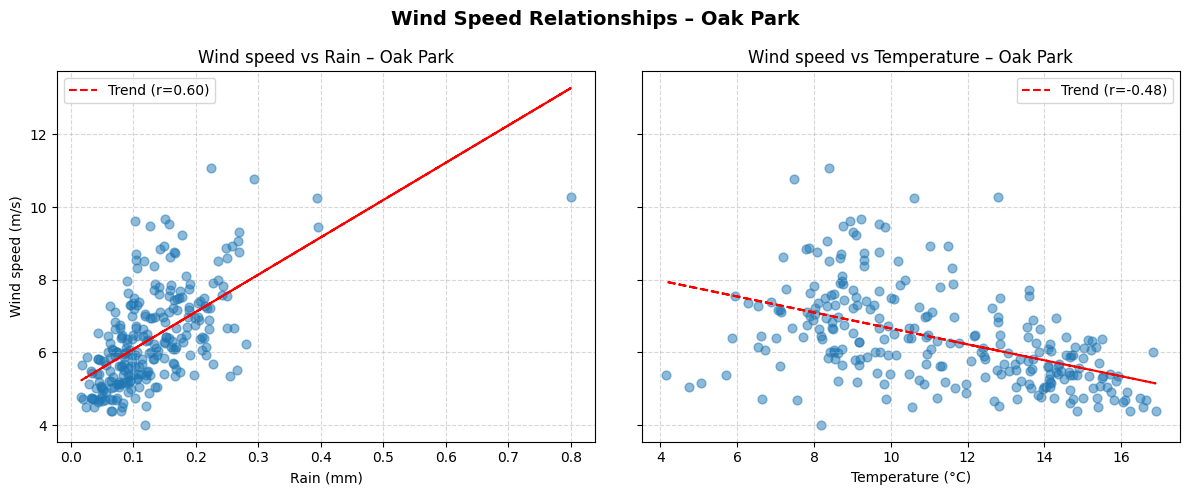

In [16]:
# Create figure with 1 row, 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)  # sharey = same y-scale

# ── Left plot: Wind vs Rain ───────────────────────────────────────
ax1.scatter(monthly["rain"], monthly["wdsp_ms"], alpha=0.5, s=40)

slope, intercept, r_value, _, _ = linregress(monthly["rain"], monthly["wdsp_ms"])
trend = intercept + slope * monthly["rain"]
ax1.plot(monthly["rain"], trend, color="red", linestyle="--",
         label=f"Trend (r={r_value:.2f})")

ax1.set_xlabel("Rain (mm)")
ax1.set_ylabel("Wind speed (m/s)")
ax1.set_title("Wind speed vs Rain – Oak Park")
ax1.legend()
ax1.grid(True, linestyle="--", alpha=0.5)

# ── Right plot: Wind vs Temperature ───────────────────────────────
ax2.scatter(monthly["temp"], monthly["wdsp_ms"], alpha=0.5, s=40)

slope, intercept, r_value, _, _ = linregress(monthly["temp"], monthly["wdsp_ms"])
trend = intercept + slope * monthly["temp"]
ax2.plot(monthly["temp"], trend, color="red", linestyle="--",
         label=f"Trend (r={r_value:.2f})")

ax2.set_xlabel("Temperature (°C)")
ax2.set_title("Wind speed vs Temperature – Oak Park")
ax2.legend()
ax2.grid(True, linestyle="--", alpha=0.5)

# Final touches
fig.suptitle("Wind Speed Relationships – Oak Park", fontsize=14, fontweight='bold')
fig.tight_layout(w_pad=3)   # nice spacing between plots

plt.show()

##

In [11]:
DATADIR = Path("stationdata")

for file in sorted(DATADIR.glob("*.csv")):
    df = pd.read_csv(file, low_memory=False)

    # Total number of rows in the file
    total_rows = len(df)

    # Number of zero values in wdsp
    zero_count = (df["wdsp"] == 0).sum()

    # Percentage of zeros
    zero_percent = (zero_count / total_rows) * 100 if total_rows > 0 else 0

    station_name = file.stem.title()

    print(
        f"{station_name}: "
        f"{zero_count} zero values out of {total_rows} rows "
        f"({zero_percent:.2f}%)"
    )

Athenry: 87 zero values out of 138168 rows (0.06%)
Ballyhaise: 239 zero values out of 194160 rows (0.12%)
Belmullet: 5862 zero values out of 606649 rows (0.97%)
Claremorris: 23503 zero values out of 665435 rows (3.53%)
Cork Airport: 1642 zero values out of 560280 rows (0.29%)
Dublin Airport: 12744 zero values out of 709293 rows (1.80%)
Dunsany: 288 zero values out of 171480 rows (0.17%)
Finner: 306 zero values out of 238729 rows (0.13%)
Gurteen: 165 zero values out of 156200 rows (0.11%)
Johnstown Castle: 651 zero values out of 195494 rows (0.33%)
Knock Airport: 393 zero values out of 257136 rows (0.15%)
Mace Head: 668 zero values out of 195480 rows (0.34%)
Malin Head: 3299 zero values out of 618768 rows (0.53%)
Moore Park: 294 zero values out of 195556 rows (0.15%)
Mt Dillon: 182 zero values out of 186109 rows (0.10%)
Mullingar: 11458 zero values out of 456408 rows (2.51%)
Newport: 26 zero values out of 182675 rows (0.01%)
Oak Park: 771 zero values out of 195496 rows (0.39%)
Roches Po

In [10]:
from pathlib import Path

data_dir = Path("stationdata")

for file in data_dir.glob("*.csv"):
    size_mb = file.stat().st_size / (1024*1024)
    print(f"{file.name} size: {size_mb:.2f} MB")

Claremorris.csv size: 81.64 MB
Valentia Observatory.csv size: 93.57 MB
Mt Dillon.csv size: 22.55 MB
Newport.csv size: 21.88 MB
Finner.csv size: 29.30 MB
Malin Head.csv size: 76.36 MB
Dublin Airport.csv size: 88.19 MB
Johnstown Castle.csv size: 24.98 MB
Ballyhaise.csv size: 23.68 MB
Gurteen.csv size: 18.68 MB
Belmullet.csv size: 74.07 MB
Oak Park.csv size: 23.48 MB
Knock Airport.csv size: 32.26 MB
Mullingar.csv size: 55.10 MB
Athenry.csv size: 16.50 MB
Dunsanny.csv size: 20.66 MB
Moore Park.csv size: 23.82 MB
Mace Head.csv size: 23.91 MB
Roches Point.csv size: 71.71 MB
Shannon Airport.csv size: 89.54 MB
Cork Airport.csv size: 68.79 MB
Sherkin Island.csv size: 24.03 MB
